## EDA & Predictive analysis on NYC Yellow Taxi data


## Import the libraries


In [5]:
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil import parser
from pyspark.sql.functions import unix_timestamp, date_format, col, when
from pyspark.ml import Pipeline
from pyspark.ml import PipelineModel
from pyspark.ml.feature import RFormula
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator

## Construct the input dataframe
The following lines retrieves the data via the Open Datasets API. Pulling all of this data generates about 1.5 billion rows. Depending on the size of the Spark pool, the raw data may be too large or take too much time to operate on. We can filter this data down to something smaller. The use of start_date and end_date applies a filter that returns a month of data.


In [7]:
from azureml.opendatasets import NycTlcYellow

end_date = parser.parse('2018-06-06')
start_date = parser.parse('2018-05-01')
nyc_tlc = NycTlcYellow(start_date=start_date, end_date=end_date)
filtered_df = nyc_tlc.to_spark_dataframe()

## Sampling
The downside to simple filtering is that, from a statistical perspective, it may introduce bias into the data. Another approach is to use the sampling built into Spark. The following code reduces the dataset down to about 2000 rows, if applied after the code above. This sampling step can be used instead of the simple filter or in conjunction with the simple filter.


In [9]:
# To make development easier, faster and less expensive down sample for now
sampled_taxi_df = filtered_df.sample(True, 0.001, seed=1234)

## Review the data
It is now possible to look at the data to see what was read. It is normally better to review data with a subset rather than the full set depending on the size of the dataset. The following code offers two ways to view the data: the former being basic and the latter providing a much richer grid experience, as well as the capability to visualize the data graphically.

In [10]:
#sampled_taxi_df.show(5)
display(sampled_taxi_df)

## Caching
Depending on the size of the dataset size generated and your need to experiment or run the notebook many times, it may be advisable to cache the dataset locally in the workspace. There are three ways to do perform explicit caching:

Save the dataframe locally as a file

Save the dataframe as a temporary table or view

Save the dataframe as a permanent table

The first 2 of these approaches are included in the following code examples.

Creating a temp table or view provides different access paths to the data, but only lasts for the duration of the Spark instance session.

In [11]:
sampled_taxi_df.createOrReplaceTempView("nytaxi")

## Visualizations
The following code shows three different visualizations of the data related to tips that lead to conclusions about the state and quality of the data.

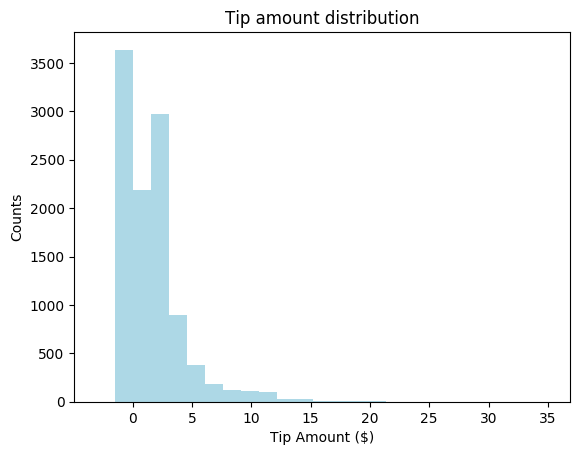

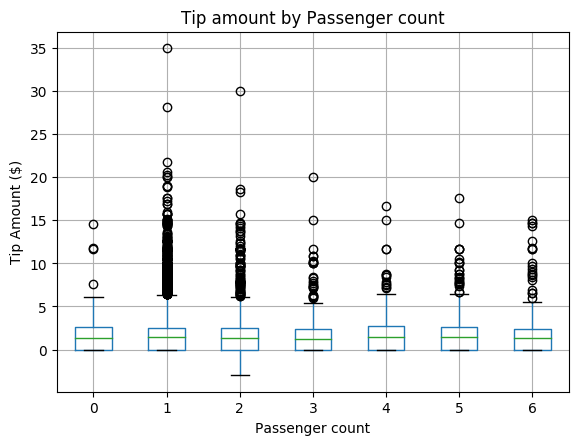

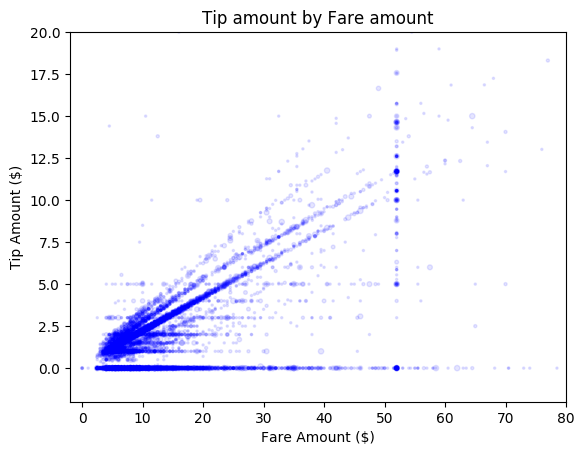

In [12]:
# The charting package needs a Pandas dataframe or numpy array do the conversion
sampled_taxi_pd_df = sampled_taxi_df.toPandas()

# Look at tips by amount count histogram
ax1 = sampled_taxi_pd_df['tipAmount'].plot(kind='hist', bins=25, facecolor='lightblue')
ax1.set_title('Tip amount distribution')
ax1.set_xlabel('Tip Amount ($)')
ax1.set_ylabel('Counts')
plt.suptitle('')
plt.show()

# How many passengers tip'd by various amounts
ax2 = sampled_taxi_pd_df.boxplot(column=['tipAmount'], by=['passengerCount'])
ax2.set_title('Tip amount by Passenger count')
ax2.set_xlabel('Passenger count')
ax2.set_ylabel('Tip Amount ($)')
plt.suptitle('')
plt.show()

# Look at the relationship between fare and tip amounts
ax = sampled_taxi_pd_df.plot(kind='scatter', x= 'fareAmount', y = 'tipAmount', c='blue', alpha = 0.10, s=2.5*(sampled_taxi_pd_df['passengerCount']))
ax.set_title('Tip amount by Fare amount')
ax.set_xlabel('Fare Amount ($)')
ax.set_ylabel('Tip Amount ($)')
plt.axis([-2, 80, -2, 20])
plt.suptitle('')
plt.show()

## Data Preparation
The data in its raw form is frequently not suitable for passing directly to a model. A series of actions must be performed on the data to get it into a state where the model can consume it.

In the code below four classes of operations are performed:

The removal of outliers/incorrect values through filtering.

The removal of columns, which are not needed.

The creation of new columns derived from the raw data to make the model work more effectively, sometimes called featurization.

Labeling, as we are undertaking binary classification (will there be a tip or not on a given trip) there is a need to convert the tip amount into a 0 or 1 value.


In [13]:
taxi_df = sampled_taxi_df.select('totalAmount', 'fareAmount', 'tipAmount', 'paymentType', 'rateCodeId', 'passengerCount'\
                                , 'tripDistance', 'tpepPickupDateTime', 'tpepDropoffDateTime'\
                                , date_format('tpepPickupDateTime', 'hh').alias('pickupHour')\
                                , date_format('tpepPickupDateTime', 'EEEE').alias('weekdayString')\
                                , (unix_timestamp(col('tpepDropoffDateTime')) - unix_timestamp(col('tpepPickupDateTime'))).alias('tripTimeSecs')\
                                , (when(col('tipAmount') > 0, 1).otherwise(0)).alias('tipped')
                                )\
                        .filter((sampled_taxi_df.passengerCount > 0) & (sampled_taxi_df.passengerCount < 8)\
                                & (sampled_taxi_df.tipAmount >= 0) & (sampled_taxi_df.tipAmount <= 25)\
                                & (sampled_taxi_df.fareAmount >= 1) & (sampled_taxi_df.fareAmount <= 250)\
                                & (sampled_taxi_df.tipAmount < sampled_taxi_df.fareAmount)\
                                & (sampled_taxi_df.tripDistance > 0) & (sampled_taxi_df.tripDistance <= 100)\
                                & (sampled_taxi_df.rateCodeId <= 5)
                                & (sampled_taxi_df.paymentType.isin({"1", "2"}))
                                )

## Add the final features.


In [14]:
taxi_featurised_df = taxi_df.select('totalAmount', 'fareAmount', 'tipAmount', 'paymentType', 'passengerCount'\
                                                , 'tripDistance', 'weekdayString', 'pickupHour','tripTimeSecs','tipped'\
                                                , when((taxi_df.pickupHour <= 6) | (taxi_df.pickupHour >= 20),"Night")\
                                                .when((taxi_df.pickupHour >= 7) & (taxi_df.pickupHour <= 10), "AMRush")\
                                                .when((taxi_df.pickupHour >= 11) & (taxi_df.pickupHour <= 15), "Afternoon")\
                                                .when((taxi_df.pickupHour >= 16) & (taxi_df.pickupHour <= 19), "PMRush")\
                                                .otherwise(0).alias('trafficTimeBins')
                                              )\
                                       .filter((taxi_df.tripTimeSecs >= 30) & (taxi_df.tripTimeSecs <= 7200))

## OneHotEncoding
The final task is to convert the labeled data into a format that can be analyzed by logistic regression. The input to a logistic regression algorithm needs to be a set of label-feature vector pairs, where the feature vector is a vector of numbers representing the input point. So, we need to convert the categorical columns into numbers. The trafficTimeBins and weekdayString columns need to be converted into integer representations. There are multiple approaches to performing the conversion, however the approach taken in this example is OneHotEncoding, a common approach.

In [15]:
# The sample uses an algorithm that only works with numeric features convert them so they can be consumed
sI1 = StringIndexer(inputCol="trafficTimeBins", outputCol="trafficTimeBinsIndex")
en1 = OneHotEncoder(dropLast=False, inputCol="trafficTimeBinsIndex", outputCol="trafficTimeBinsVec")
sI2 = StringIndexer(inputCol="weekdayString", outputCol="weekdayIndex")
en2 = OneHotEncoder(dropLast=False, inputCol="weekdayIndex", outputCol="weekdayVec")

# Create a new dataframe that has had the encodings applied
encoded_final_df = Pipeline(stages=[sI1, en1, sI2, en2]).fit(taxi_featurised_df).transform(taxi_featurised_df)

In [17]:
display(encoded_final_df)

## Visualization with trip distance


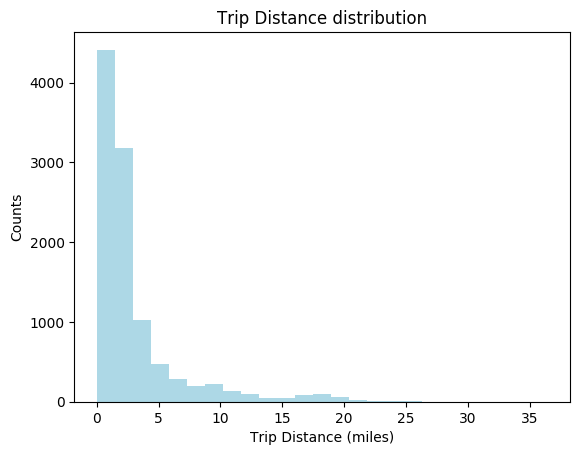

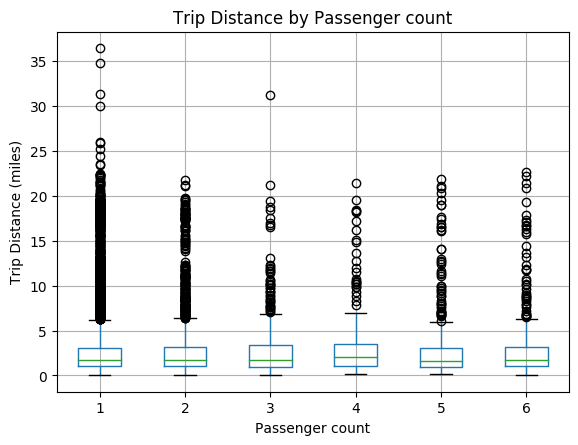

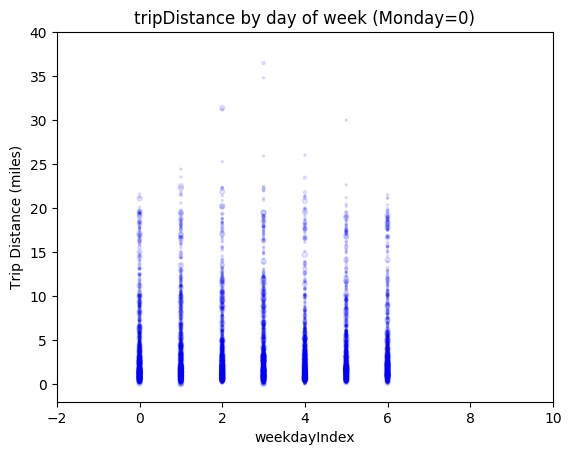


/opt/spark/python/lib/pyspark.zip/pyspark/sql/dataframe.py:2103: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.fallback.enabled' is set to true.
  warnings.warn(msg)

In [18]:
# The charting package needs a Pandas dataframe or numpy array do the conversion
encoded_final_pd_df = encoded_final_df.toPandas()

# Look at tripDistance histogram
ax1 = encoded_final_pd_df['tripDistance'].plot(kind='hist', bins=25, facecolor='lightblue')
ax1.set_title('Trip Distance distribution')
ax1.set_xlabel('Trip Distance (miles)')
ax1.set_ylabel('Counts')
plt.suptitle('')
plt.show()

# How many passengers rode for various miles
ax2 = encoded_final_pd_df.boxplot(column=['tripDistance'], by=['passengerCount'])
ax2.set_title('Trip Distance by Passenger count')
ax2.set_xlabel('Passenger count')
ax2.set_ylabel('Trip Distance (miles)')
plt.suptitle('')
plt.show()

# Look at the relationship between weekdayIndex and tripDistance
ax = encoded_final_pd_df.plot(kind='scatter', x= 'weekdayIndex', y = 'tripDistance', c='blue', alpha = 0.10, s=2.5*(sampled_taxi_pd_df['passengerCount']))
ax.set_title('tripDistance by day of week (Monday=0)')
ax.set_xlabel('weekdayIndex')
ax.set_ylabel('Trip Distance (miles)')
plt.axis([-2, 10, -2, 40])
plt.suptitle('')
plt.show()

## Summary Statitics


In [19]:
encoded_final_df_1 = encoded_final_df.select('fareAmount','tipAmount','paymentType'
,'passengerCount','tripDistance')
encoded_final_df_1.describe().show()

+-------+------------------+------------------+------------------+------------------+------------------+
|summary|        fareAmount|         tipAmount|       paymentType|    passengerCount|      tripDistance|
+-------+------------------+------------------+------------------+------------------+------------------+
|  count|             10400|             10400|             10400|             10400|             10400|
|   mean|13.239667307692306|1.9215605769230755| 1.300096153846154|1.6465384615384615|3.0251769230769225|
| stddev|11.021411864954496| 2.419400809325458|0.4583215576863453|1.2819875973244659|  3.74366697952015|
|    min|               2.5|               0.0|                 1|                 1|              0.01|
|    max|             200.0|             21.81|                 2|                 6|             36.48|
+-------+------------------+------------------+------------------+------------------+------------------+

In [20]:
encoded_final_df_2 = encoded_final_df.select('weekdayString','pickupHour','tipped'
,'tripTimeSecs','trafficTimeBins')
encoded_final_df_2.describe().show()

+-------+-------------+------------------+-------------------+-----------------+---------------+
|summary|weekdayString|        pickupHour|             tipped|     tripTimeSecs|trafficTimeBins|
+-------+-------------+------------------+-------------------+-----------------+---------------+
|  count|        10400|             10400|              10400|            10400|          10400|
|   mean|         null| 6.986826923076923| 0.6683653846153846|898.3422115384616|           null|
| stddev|         null|3.3555702132068808|0.47082312189465797|719.2999313876454|           null|
|    min|       Friday|                01|                  0|               34|         AMRush|
|    max|    Wednesday|                12|                  1|             6704|          Night|
+-------+-------------+------------------+-------------------+-----------------+---------------+

## Build a logistic regression model


## Step1: Create Train Test Data set

The first task is to split the dataset into a training set and a testing or validation set. I took a 70:30 split for training to testing.

In [21]:
#Decide on the split between training and testing data from the dataframe
trainingFraction = 0.7
testingFraction = (1-trainingFraction)
seed = 1234

# Split the dataframe into test and training dataframes
train_data_df, test_data_df = encoded_final_df.randomSplit([trainingFraction, testingFraction], seed=seed)

## Step2: Create Model
The second task is to select a formula and create the model.

Logistic regression is an algorithm that we can use for classification. Spark's logistic regression API is useful for binary classification, or classifying input data into one of two groups. The process of logistic regression produces a logistic function that can be used to predict the probability that an input vector belongs in one group or the other.


In [22]:
## Create a new LR object for the model
logReg = LogisticRegression(maxIter=10, regParam=0.3, labelCol = 'tipped')

## The formula for the model
##formula="tipped ~ pickupHour + weekdayVec +/
##             passengerCount + tripTimeSecs + tripDistance +/ 
##             fareAmount + paymentType+ trafficTimeBinsVec"

classFormula = RFormula(formula="tipped ~ pickupHour + weekdayVec + passengerCount + tripTimeSecs + tripDistance + fareAmount + paymentType+ trafficTimeBinsVec")

## Undertake training and create an LR model
lrModel = Pipeline(stages=[classFormula, logReg]).fit(train_data_df)

## Saving the model is optional but its another form of inter session cache
datestamp = datetime.now().strftime('%m-%d-%Y-%s')
fileName = "lrModel_" + datestamp
logRegDirfilename = fileName

## Step3: Test Model

The third task is to test the model. AUROC  (Area Under the Receiver Operating Characteristics) can be computed using the trapezoidal rule. In general, an AUC of 0.5 suggests no discrimination (i.e., ability to diagnose patients with and without the disease or condition based on the test), 0.7 to 0.8 is considered acceptable, 0.8 to 0.9 is considered excellent, and more than 0.9 is considered outstanding.

In [23]:
## Predict tip 1/0 (yes/no) on the test dataset, evaluation using AUROC
predictions = lrModel.transform(test_data_df)
predictionAndLabels = predictions.select("label","prediction").rdd
metrics = BinaryClassificationMetrics(predictionAndLabels)
print("Area under ROC = %s" % metrics.areaUnderROC)

Area under ROC = 0.9755244755244755

## Step4: Visualize the prediction
When we need to check or visualize the performance of classification problem, we use AUC (Area Under The Curve) ROC (Receiver Operating Characteristics) curve. It is one of the most important evaluation metrics for checking any classification model’s performance. It is also written as AUROC (Area Under the Receiver Operating Characteristics)

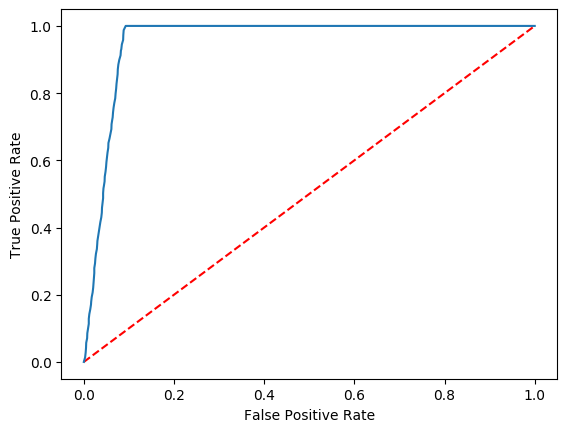

In [24]:
## Plot the ROC curve, no need for pandas as this uses the modelSummary object
modelSummary = lrModel.stages[-1].summary

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(modelSummary.roc.select('FPR').collect(),
         modelSummary.roc.select('TPR').collect())
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()